In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imageio.v3 as imageio
import pandas as pd
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import ImageGrid
from scratch.illustrate.violin import ViolinPlot
from scratch.algos.rays import compute_cdf


plt.rcParams.update({
    'font.family': 'serif'
})

FONTSIZE=14
SMALLER_FONTSIZE=12

In [57]:
def compute_alpha(func, x, d):
    a = 1. - torch.exp(-func(x) * d)
    return a

raw_features = torch.linspace(-20, 20, 10001)
pretty_d = {
    1e3: "1e3",
    1e2: "1e2",
    1e1: "1e1",
    1e0: "1e0",
    1e-1: "1e-1",
    1e-2: "1e-2",
    1e-3: "1e-3",
}

The following code block applies the $\mathtt{exp}$ activation function onto the raw feature vectors.

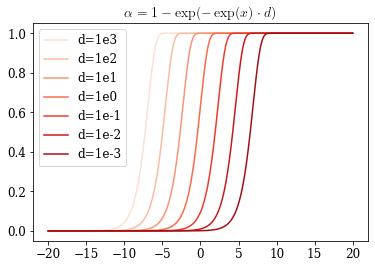

In [7]:
fig, ax = plt.subplots()
shades = sns.color_palette("Reds", 7)
for distance_scale in [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3]:
    sigmas = compute_alpha(torch.exp, raw_features, distance_scale)
    ax.plot(raw_features, sigmas, label=f"d={pretty_d[distance_scale]}", color=shades.pop(0))

ax.set_title(r"$\alpha = 1 - \exp(-\exp(x) \cdot d)$", fontsize=FONTSIZE, usetex=True)
ax.legend(fontsize=SMALLER_FONTSIZE)
ax.tick_params(labelsize=SMALLER_FONTSIZE)
plt.savefig('exp.pdf', bbox_inches='tight', dpi=300)
plt.show()

The following code block applies the $\mathtt{softplus}$ activation function onto the raw feature vectors.

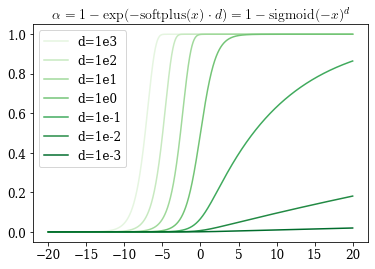

In [8]:
fig, ax = plt.subplots()
shades = sns.color_palette("Greens", 7)
for distance_scale in [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3]:
    sigmas = compute_alpha(F.softplus, raw_features, distance_scale)
    ax.plot(raw_features, sigmas, label=f"d={pretty_d[distance_scale]}", color=shades.pop(0))

ax.set_title(r"$\alpha = 1 - \exp(-\mathrm{softplus}(x) \cdot d) = 1 - \mathrm{sigmoid}(-x)^d$", fontsize=FONTSIZE, usetex=True)
ax.legend(fontsize=SMALLER_FONTSIZE)
ax.tick_params(labelsize=SMALLER_FONTSIZE)
plt.savefig('softplus.pdf', bbox_inches='tight', dpi=300)
plt.show()

The following code block applies the $\mathtt{relu}$ activation function onto the raw feature vectors.

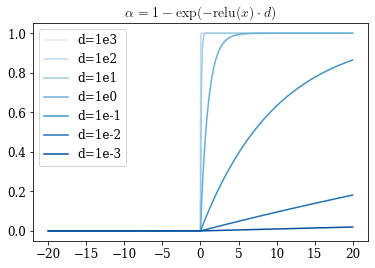

In [9]:
fig, ax = plt.subplots()
shades = sns.color_palette("Blues", 7)
for distance_scale in [1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3]:
    sigmas = compute_alpha(torch.relu, raw_features, distance_scale)
    ax.plot(raw_features, sigmas, label=f"d={pretty_d[distance_scale]}", color=shades.pop(0))

ax.set_title(r"$\alpha = 1 - \exp(-\mathrm{relu}(x) \cdot d)$", fontsize=FONTSIZE, usetex=True)
ax.legend(fontsize=SMALLER_FONTSIZE)
ax.tick_params(labelsize=SMALLER_FONTSIZE)
plt.savefig('relu.pdf', bbox_inches='tight', dpi=300)
plt.show()

CDF Plot of Nerf-Pytorch on Lego

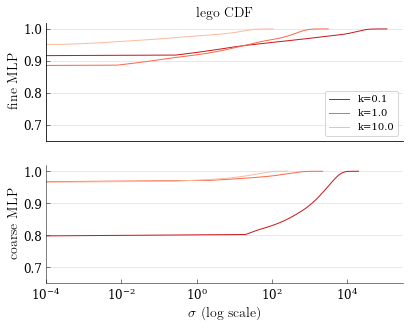

In [69]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 4.8))    # ax1 refers to the top plot, ax2 to the bottom plot
blue_shades = sns.color_palette("Reds", 3)
green_shades = sns.color_palette("Reds", 3)
bins_count = 1000

sns.despine()
ax1.set_title(f"lego CDF", fontsize=FONTSIZE, usetex=True)
# fig.supylabel("cumulative distribution function", fontsize=FONTSIZE, usetex=True)

ax1.set_xscale('log')
ax2.set_xscale('log')
ax2.set_xlabel(r"$\sigma$ (log scale)", fontsize=FONTSIZE, usetex=True)
ax2.set_ylabel('coarse MLP', fontsize=FONTSIZE, usetex=True)
ax1.set_ylabel('fine MLP', fontsize=FONTSIZE, usetex=True)

mapping = {
    0: 0.1,
    1: 1.0,
    2: 10.0
}

for mlp in ['coarse', 'fine']:
    colors = blue_shades if mlp == 'coarse' else green_shades
    ax = ax1 if mlp == 'coarse' else ax2
    for i in range(3):
        sigmas = torch.load(f"{mapping[i]}_{mlp}.pt")
        cdf, bins = compute_cdf(sigmas, bins_count)
        cdf = torch.cat([torch.tensor([0.0]), cdf])
        if ax == ax1:
            ax.plot(bins, cdf, linewidth=1.0, color=colors[2-i], label=f"k={mapping[i]}")
        else:
            ax.plot(bins, cdf, linewidth=1.0, color=colors[2-i])

# set x and y limits for both plots and remove minor ticks
bottom, top = 0.65, 1.02
ax1.set_ylim([bottom, top])
ax1.set_xticks([])
ax1.set_xticklabels([])
ax2.set_ylim([bottom, top])
ax2.set_xlim([1e-4, 3e5])
ax1.minorticks_off()
ax2.minorticks_off()

for spine in ax2.spines.values():
    spine.set_linewidth(0.5)
    spine.set_color('black')
ax2.tick_params(direction='in', axis='both', width=0.5, color='black', length=4, labelsize=SMALLER_FONTSIZE)
ax2.yaxis.grid(True, which='both', linewidth=0.5, color='lightgray')
ax1.tick_params(direction='in', axis='both', width=0.5, color='black', length=4, labelsize=SMALLER_FONTSIZE)
ax1.yaxis.grid(True, which='both', linewidth=0.5, color='lightgray')

ax1.legend(loc='lower right')
fig.savefig(f"lego_cdf.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

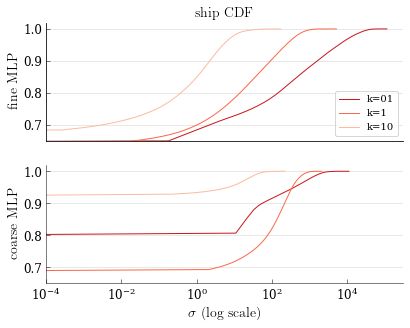

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 4.8))    # ax1 refers to the top plot, ax2 to the bottom plot
blue_shades = sns.color_palette("Reds", 3)
green_shades = sns.color_palette("Reds", 3)
bins_count = 1000

sns.despine()
ax1.set_title(f"ship CDF", fontsize=FONTSIZE, usetex=True)
# fig.supylabel("cumulative distribution function", fontsize=FONTSIZE, usetex=True)

ax1.set_xscale('log')
ax2.set_xscale('log')
ax2.set_xlabel(r"$\sigma$ (log scale)", fontsize=FONTSIZE, usetex=True)
ax2.set_ylabel('coarse MLP', fontsize=FONTSIZE, usetex=True)
ax1.set_ylabel('fine MLP', fontsize=FONTSIZE, usetex=True)

mapping = {
    0: '01',
    1: '1',
    2: '10'
}

# plot coarse MLP info here
colors = blue_shades
for i in range(3):
    sigmas = torch.load(f"ship_coarse_{mapping[i]}_sigma.pt")
    cdf, bins = compute_cdf(sigmas, bins_count)
    cdf = torch.cat([torch.tensor([0.0]), cdf])
    ax1.plot(bins, cdf, linewidth=1.0, color=colors[2-i], label=f"k={mapping[i]}")

colors = green_shades   # fine MLP
for i in range(3):
    sigmas = torch.load(f"ship_fine_{mapping[i]}_sigma.pt")
    cdf, bins = compute_cdf(sigmas, bins_count)
    cdf = torch.cat([torch.tensor([0.0]), cdf])
    ax2.plot(bins, cdf, linewidth=1.0, color=colors[2-i])

# set x and y limits for both plots and remove minor ticks
bottom, top = 0.65, 1.02
ax1.set_ylim([bottom, top])
ax1.set_xticks([])
ax1.set_xticklabels([])
ax2.set_ylim([bottom, top])
ax2.set_xlim([1e-4, 3e5])
ax1.minorticks_off()
ax2.minorticks_off()

for spine in ax2.spines.values():
    spine.set_linewidth(0.5)
    spine.set_color('black')
ax2.tick_params(direction='in', axis='both', width=0.5, color='black', length=4, labelsize=SMALLER_FONTSIZE)
ax2.yaxis.grid(True, which='both', linewidth=0.5, color='lightgray')
ax1.tick_params(direction='in', axis='both', width=0.5, color='black', length=4, labelsize=SMALLER_FONTSIZE)
ax1.yaxis.grid(True, which='both', linewidth=0.5, color='lightgray')

ax1.legend(loc='lower right')
fig.savefig(f"ship_cdf.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [11]:
violin = ViolinPlot()
coarse = [torch.load(f"{mapping[i]}_coarse.pt").numpy() for i in range(3)]
fine = [torch.load(f"{mapping[i]}_fine.pt").numpy() for i in range(3)]

df = violin._extract_pandas_df(True, ['distance_scale', 'sigma_distribution', 'mlp'],
                               [[0, 1, 2], coarse, 'coarse'], [[0, 1, 2], fine, 'fine'])

df.to_pickle('lego_cdf_violin.pkl')

Here, I try a Violin Plot representation at the above data, I suspect it is better designed for this specific use case.

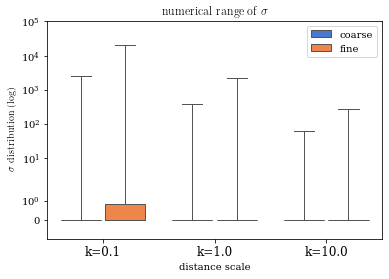

In [3]:
# generate box-and-whisker plot of the above CDF data
mapping = {
    0: 0.1,
    1: 1.0,
    2: 10.0
}

df = pd.read_pickle('lego_cdf_violin.pkl')
sns.boxplot(x='distance_scale', y='sigma_distribution', hue='mlp', data=df, palette='muted',
            linewidth=1.0, saturation=1.0, showfliers=False,
            gap=0.1, whis=[0, 100])

# manually change the IQR calculation in the boxplot to be [0.1, 0.9] instead of [0.25, 0.75]
# this is because the violin plot is already showing the IQR
# https://stackoverflow.com/questions/58420883/how-to-change-the-percentiles-of-a-boxplot-in-seaborn

plt.yscale('symlog')
plt.ylim([-1, 1e5])
plt.xlabel('distance scale')
plt.xticks([0, 1, 2], ['k=0.1', 'k=1.0', 'k=10.0'], fontsize=SMALLER_FONTSIZE)
plt.ylabel(r'$\sigma$ distribution (log)', usetex=True)
plt.title(r'numerical range of $\sigma$', usetex=True)
plt.legend(loc='best')
plt.savefig('lego_cdf_boxplot.pdf', bbox_inches='tight', dpi=300)
plt.show()


50th-percentile $\sigma$ Visualization from Nerfacto on Garden and Bicycle with both colorbar schemes

In [3]:
def process_sigmas(sigmas, lower=1e-4, upper=1e4):
    sigmas[sigmas < lower] = lower
    sigmas[sigmas > upper] = upper
    return sigmas

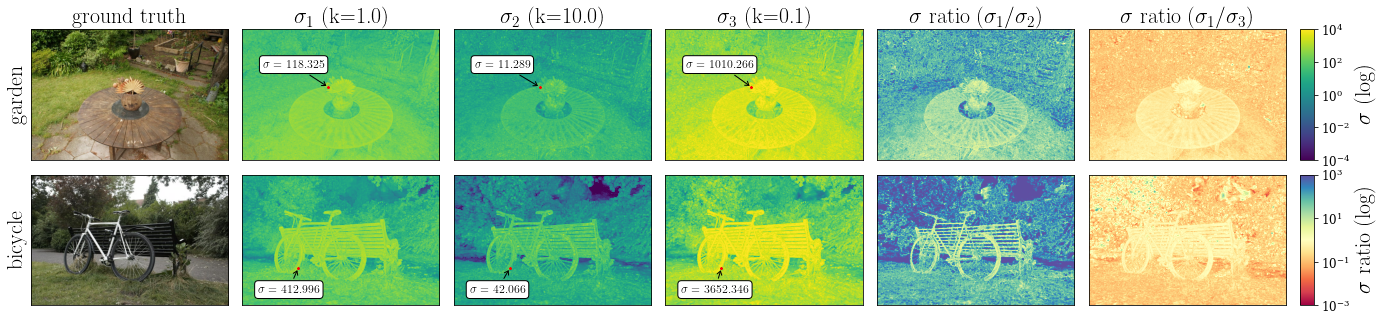

In [51]:
lower, upper = 1e-4, 1e4
ratio_lower, ratio_upper = 1e-3, 1e3
FONTSIZE=22

fig = plt.figure(figsize=(23, 8))
grid = ImageGrid(
    fig, 111, nrows_ncols=(2, 6), axes_pad=0.2,
    cbar_location="right", cbar_mode="edge", cbar_size="7%", cbar_pad=0.2,
)

# force all plots in grid to be normalized to dimensions of bicycle image
for index in range(12):
    grid[index].set_xlim([0, 618])
    grid[index].set_ylim([410, 0])

# extract garden data
garden_gt = imageio.imread('garden_gt.JPG')
k_01 = process_sigmas(np.load("garden_01.npy").squeeze(), lower, upper)
k_1 = process_sigmas(np.load("garden_1.npy").squeeze(), lower, upper)
k_10 = process_sigmas(np.load("garden_10.npy").squeeze(), lower, upper)
height, width = k_01.shape

grid[0].imshow(garden_gt)
grid[0].set_title("ground truth", fontsize=FONTSIZE, usetex=True)
cb_base = grid[1].imshow(k_1.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[1].set_title(r"$\sigma_1$ (k=1.0)", fontsize=FONTSIZE, usetex=True)
grid[2].imshow(k_10.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[2].set_title(r"$\sigma_2$ (k=10.0)", fontsize=FONTSIZE, usetex=True)
grid[3].imshow(k_01.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[3].set_title(r"$\sigma_3$ (k=0.1)", fontsize=FONTSIZE, usetex=True)

grid[1].scatter(269, 181, color='red', marker='*', s=5)
grid[1].annotate(r"$\sigma = 118.325$", xy=(269, 181), xytext=(65, 120), fontsize=SMALLER_FONTSIZE, usetex=True, color='black',
                 arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->,head_width=0.2,head_length=0.3'),
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
grid[2].scatter(269, 181, color='red', marker='*', s=5)
grid[2].annotate(r"$\sigma = 11.289$", xy=(269, 181), xytext=(65, 120), fontsize=SMALLER_FONTSIZE, usetex=True, color='black',
                 arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->,head_width=0.2,head_length=0.3'),
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
grid[3].scatter(269, 181, color='red', marker='*', s=5)
grid[3].annotate(r"$\sigma = 1010.266$", xy=(269, 181), xytext=(65, 120), fontsize=SMALLER_FONTSIZE, usetex=True, color='black',
                 arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->,head_width=0.2,head_length=0.3'),
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

high_ratio = process_sigmas(process_sigmas(np.load("garden_1.npy").squeeze(), ratio_lower, 1e2) / process_sigmas(np.load("garden_10.npy").squeeze(), ratio_lower, 1e2), ratio_lower, 1e2)
low_ratio = process_sigmas(process_sigmas(np.load("garden_1.npy").squeeze(), ratio_lower, ratio_upper) / process_sigmas(np.load("garden_01.npy").squeeze(), ratio_lower, ratio_upper), ratio_lower, 1e2)
grid[4].imshow(high_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, 1e2))
grid[4].set_title(r"$\sigma$ ratio ($\sigma_1 / \sigma_2$)", fontsize=FONTSIZE, usetex=True)
cb_ratio = grid[5].imshow(low_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
grid[5].set_title(r"$\sigma$ ratio ($\sigma_1 / \sigma_3$)", fontsize=FONTSIZE, usetex=True)

# extract bicycle data
bicycle_gt = imageio.imread('bicycle_gt.JPG')
k_01 = process_sigmas(np.load("bicycle_01.npy").squeeze(), lower, upper)
k_1 = process_sigmas(np.load("bicycle_1.npy").squeeze(), lower, upper)
k_10 = process_sigmas(np.load("bicycle_10.npy").squeeze(), lower, upper)
height, width = k_01.shape

grid[6].imshow(bicycle_gt)
grid[7].imshow(k_1.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[8].imshow(k_10.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[9].imshow(k_01.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))

grid[7].scatter(175, 294, color='red', marker='*', s=5)
grid[7].annotate(r"$\sigma = 412.996$", xy=(175, 294), xytext=(50, 370), fontsize=SMALLER_FONTSIZE, usetex=True, color='black',
                 arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->,head_width=0.2,head_length=0.3'),
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
grid[8].scatter(175, 294, color='red', marker='*', s=5)
grid[8].annotate(r"$\sigma = 42.066$", xy=(175, 294), xytext=(50, 370), fontsize=SMALLER_FONTSIZE, usetex=True, color='black',
                 arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->,head_width=0.2,head_length=0.3'),
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
grid[9].scatter(175, 294, color='red', marker='*', s=5)
grid[9].annotate(r"$\sigma = 3652.346$", xy=(175, 294), xytext=(50, 370), fontsize=SMALLER_FONTSIZE, usetex=True, color='black',
                 arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->,head_width=0.2,head_length=0.3'),
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

high_ratio = process_sigmas(process_sigmas(np.load("bicycle_1.npy").squeeze(), ratio_lower, 1e2) / process_sigmas(np.load("bicycle_10.npy").squeeze(), ratio_lower, 1e2), ratio_lower, 1e2)
low_ratio = process_sigmas(process_sigmas(np.load("bicycle_1.npy").squeeze(), ratio_lower, ratio_upper) / process_sigmas(np.load("bicycle_01.npy").squeeze(), ratio_lower, ratio_upper), ratio_lower, 1e2)
grid[10].imshow(high_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, 1e2))
grid[11].imshow(low_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))

for index in range(12):
    grid[index].get_xaxis().set_visible(False)
    if index not in [0, 6]:
        grid[index].get_yaxis().set_visible(False)

# colorbars and labels
sigma = plt.colorbar(cb_base, cax=grid.cbar_axes[0])
sigma.set_label(r"$\sigma$ (log)", fontsize=FONTSIZE, usetex=True)
sigma.ax.tick_params(labelsize=SMALLER_FONTSIZE)

sigma_r = plt.colorbar(cb_ratio, cax=grid.cbar_axes[1])
sigma_r.set_label(r"$\sigma$ ratio (log)", fontsize=FONTSIZE, usetex=True)
sigma_r.ax.tick_params(labelsize=SMALLER_FONTSIZE)

grid[0].set_ylabel("garden", fontsize=FONTSIZE, usetex=True)
grid[0].set_yticks([])
grid[6].set_ylabel("bicycle", fontsize=FONTSIZE, usetex=True)
grid[6].set_yticks([])

plt.savefig(f"360_combo.pdf", dpi=300, bbox_inches='tight')
plt.show()

FONTSIZE=14

50th-percentile $\sigma$ Visualization from Vanilla-NeRF on Drums and Hotdog with both colorbar schemes

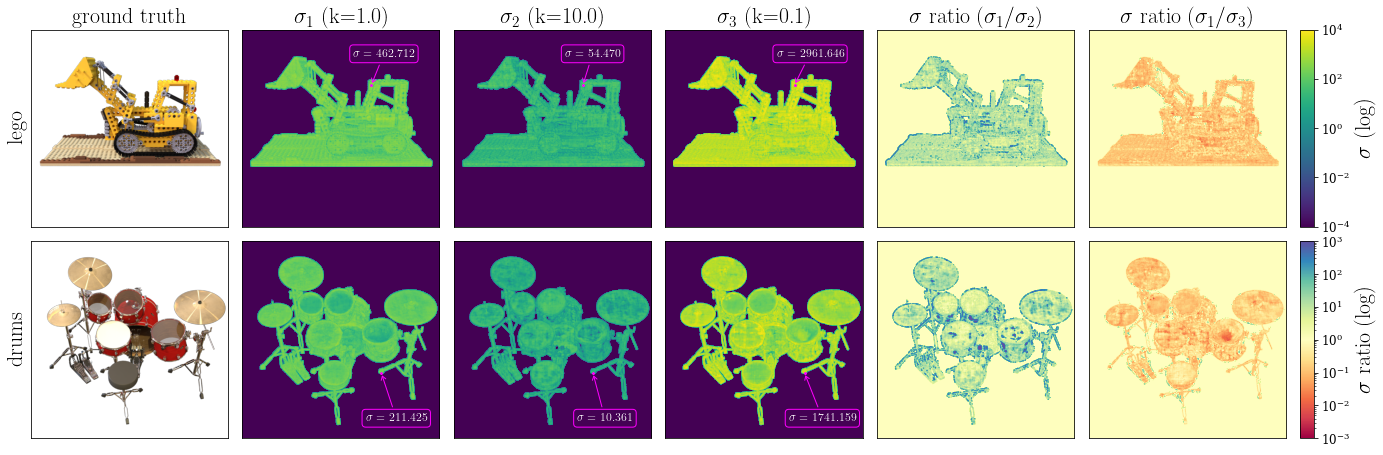

In [12]:
# lower, upper = 5e-3, 5e3
lower, upper = 1e-4, 1e4
ratio_lower, ratio_upper = 1e-3, 1e3
FONTSIZE=22

fig = plt.figure(figsize=(23, 8))
grid = ImageGrid(
    fig, 111, nrows_ncols=(2, 6), axes_pad=0.2,
    cbar_location="right", cbar_mode="edge", cbar_size="7%", cbar_pad=0.2,
)

# extract hotdog data
# hotdog_gt = imageio.imread('hotdog_gt.png')
# k_01 = process_sigmas(torch.load("hotdog_01.pt", map_location=torch.device('cpu')).squeeze(), lower, upper).reshape(800,800)
# k_1 = process_sigmas(torch.load("hotdog_1.pt", map_location=torch.device('cpu')).squeeze(), lower, upper).reshape(800,800)
# k_10 = process_sigmas(torch.load("hotdog_10.pt", map_location=torch.device('cpu')).squeeze(), lower, upper).reshape(800,800)
# height, width = k_01.shape

# mask1, mask2 = np.where(hotdog_gt.sum(-1) == 0)   # mask out empty pixels
# k_01[mask1, mask2] = lower
# k_1[mask1, mask2] = lower
# k_10[mask1, mask2] = lower

# grid[0].imshow(hotdog_gt)
# grid[0].set_title("ground truth", fontsize=FONTSIZE, usetex=True)
# cb_base = grid[1].imshow(k_1.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
# grid[1].set_title(r"$\sigma_1$ (k=1.0)", fontsize=FONTSIZE, usetex=True)
# grid[2].imshow(k_10.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
# grid[2].set_title(r"$\sigma_2$ (k=10.0)", fontsize=FONTSIZE, usetex=True)
# grid[3].imshow(k_01.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
# grid[3].set_title(r"$\sigma_3$ (k=0.1)", fontsize=FONTSIZE, usetex=True)

# grid[1].scatter(284, 506, color='magenta', marker='*', s=5)
# grid[1].annotate(r"$\sigma = 274.175$", xy=(284, 506), xytext=(50, 750), fontsize=SMALLER_FONTSIZE, usetex=True, color='white',
#                  arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->,head_width=0.2,head_length=0.3'),
#                  bbox=dict(boxstyle='round,pad=0.3', edgecolor='magenta', facecolor=(1, 1, 1, 0.0)))
# grid[2].scatter(284, 506, color='magenta', marker='*', s=5)
# grid[2].annotate(r"$\sigma = 6.531$", xy=(284, 506), xytext=(50, 750), fontsize=SMALLER_FONTSIZE, usetex=True, color='white',
#                  arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->,head_width=0.2,head_length=0.3'),
#                  bbox=dict(boxstyle='round,pad=0.3', edgecolor='magenta', facecolor=(1, 1, 1, 0.0)))
# grid[3].scatter(284, 506, color='magenta', marker='*', s=5)
# grid[3].annotate(r"$\sigma = 1855.945$", xy=(284, 506), xytext=(50, 750), fontsize=SMALLER_FONTSIZE, usetex=True, color='white',
#                  arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->,head_width=0.2,head_length=0.3'),
#                  bbox=dict(boxstyle='round,pad=0.3', edgecolor='magenta', facecolor=(1, 1, 1, 0.0)))

# high_ratio = process_sigmas(k_1 / k_10, ratio_lower, ratio_upper)
# high_ratio[high_ratio < 1] *= 10
# low_ratio = process_sigmas(k_1 / k_01, ratio_lower, ratio_upper)
# low_ratio[low_ratio > 1] /= 10
# cb_ratio = grid[4].imshow(high_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
# grid[4].set_title(r"$\sigma$ ratio ($\sigma_1 / \sigma_2$)", fontsize=FONTSIZE, usetex=True)
# grid[5].imshow(low_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
# grid[5].set_title(r"$\sigma$ ratio ($\sigma_1 / \sigma_3$)", fontsize=FONTSIZE, usetex=True)

# extract lego data
lego_gt = imageio.imread('lego_gt_75.png')
k_01 = process_sigmas(torch.load("vanilla_lego_01_p75.pt", map_location=torch.device('cpu')).squeeze(), lower, upper).reshape(800,800)
k_1 = process_sigmas(torch.load("vanilla_lego_1_p75.pt", map_location=torch.device('cpu')).squeeze(), lower, upper).reshape(800,800)
k_10 = process_sigmas(torch.load("vanilla_lego_10_p75.pt", map_location=torch.device('cpu')).squeeze(), lower, upper).reshape(800,800)
height, width = k_01.shape

mask1, mask2 = np.where(lego_gt.sum(-1) == 0)
k_01[mask1, mask2] = lower
k_1[mask1, mask2] = lower
k_10[mask1, mask2] = lower

grid[0].imshow(lego_gt)
grid[0].set_title("ground truth", fontsize=FONTSIZE, usetex=True)
cb_base = grid[1].imshow(k_1.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[1].set_title(r"$\sigma_1$ (k=1.0)", fontsize=FONTSIZE, usetex=True)
grid[2].imshow(k_10.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[2].set_title(r"$\sigma_2$ (k=10.0)", fontsize=FONTSIZE, usetex=True)
grid[3].imshow(k_01.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[3].set_title(r"$\sigma_3$ (k=0.1)", fontsize=FONTSIZE, usetex=True)

grid[1].scatter(523, 224, color='magenta', marker='*', s=5)
grid[1].annotate(r"$\sigma = 462.712$", xy=(523, 224), xytext=(450, 110), fontsize=SMALLER_FONTSIZE, usetex=True, color='white',
                 arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->,head_width=0.2,head_length=0.3'),
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='magenta', facecolor=(1, 1, 1, 0.0)))
grid[2].scatter(523, 224, color='magenta', marker='*', s=5)
grid[2].annotate(r"$\sigma = 54.470$", xy=(523, 224), xytext=(450, 110), fontsize=SMALLER_FONTSIZE, usetex=True, color='white',
                 arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->,head_width=0.2,head_length=0.3'),
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='magenta', facecolor=(1, 1, 1, 0.0)))
grid[3].scatter(523, 224, color='magenta', marker='*', s=5)
grid[3].annotate(r"$\sigma = 2961.646$", xy=(523, 224), xytext=(450, 110), fontsize=SMALLER_FONTSIZE, usetex=True, color='white',
                 arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->,head_width=0.2,head_length=0.3'),
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='magenta', facecolor=(1, 1, 1, 0.0)))

high_ratio = process_sigmas(k_1 / k_10, ratio_lower, ratio_upper)
high_ratio[high_ratio < 1] *= 10
low_ratio = process_sigmas(k_1 / k_01, ratio_lower, ratio_upper)
low_ratio[low_ratio > 1] /= 10
cb_ratio = grid[4].imshow(high_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
grid[4].set_title(r"$\sigma$ ratio ($\sigma_1 / \sigma_2$)", fontsize=FONTSIZE, usetex=True)
grid[5].imshow(low_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
grid[5].set_title(r"$\sigma$ ratio ($\sigma_1 / \sigma_3$)", fontsize=FONTSIZE, usetex=True)

# extract drums data
drums_gt = imageio.imread('drums_gt.png')
k_01 = process_sigmas(torch.load("drums_01.pt", map_location=torch.device('cpu')).squeeze(), lower, upper).reshape(800,800)
k_1 = process_sigmas(torch.load("drums_1.pt", map_location=torch.device('cpu')).squeeze(), lower, upper).reshape(800,800)
k_10 = process_sigmas(torch.load("drums_10.pt", map_location=torch.device('cpu')).squeeze(), lower, upper).reshape(800,800)
height, width = k_01.shape

mask1, mask2 = np.where(drums_gt.sum(-1) == 0)
k_01[mask1, mask2] = lower
k_1[mask1, mask2] = lower
k_10[mask1, mask2] = lower

grid[6].imshow(drums_gt)
grid[7].imshow(k_1.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[8].imshow(k_10.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[9].imshow(k_01.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))

grid[7].scatter(564, 536, color='magenta', marker='*', s=5)
grid[7].annotate(r"$\sigma = 211.425$", xy=(564, 536), xytext=(500, 730), fontsize=SMALLER_FONTSIZE, usetex=True, color='white',
                    arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->,head_width=0.2,head_length=0.3'),
                    bbox=dict(boxstyle='round,pad=0.3', edgecolor='magenta', facecolor=(1, 1, 1, 0.0)))
grid[8].scatter(564, 536, color='magenta', marker='*', s=5)
grid[8].annotate(r"$\sigma = 10.361$", xy=(564, 536), xytext=(500, 730), fontsize=SMALLER_FONTSIZE, usetex=True, color='white',
                    arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->,head_width=0.2,head_length=0.3'),
                    bbox=dict(boxstyle='round,pad=0.3', edgecolor='magenta', facecolor=(1, 1, 1, 0.0)))
grid[9].scatter(564, 536, color='magenta', marker='*', s=5)
grid[9].annotate(r"$\sigma = 1741.159$", xy=(564, 536), xytext=(500, 730), fontsize=SMALLER_FONTSIZE, usetex=True, color='white',
                    arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->,head_width=0.2,head_length=0.3'),
                    bbox=dict(boxstyle='round,pad=0.3', edgecolor='magenta', facecolor=(1, 1, 1, 0.0)))

high_ratio = process_sigmas(k_1 / k_10, ratio_lower, ratio_upper)
high_ratio[high_ratio < 1] *= 10
low_ratio = process_sigmas(k_1 / k_01, ratio_lower, ratio_upper)
low_ratio[low_ratio > 1] /= 10
grid[10].imshow(high_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
grid[11].imshow(low_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))

for index in range(12):
    grid[index].get_xaxis().set_visible(False)
    if index not in [0, 6]:
        grid[index].get_yaxis().set_visible(False)

# colorbars and labels
sigma = plt.colorbar(cb_base, cax=grid.cbar_axes[0])
sigma.set_label(r"$\sigma$ (log)", fontsize=FONTSIZE, usetex=True)
sigma.ax.tick_params(labelsize=SMALLER_FONTSIZE)

sigma_r = plt.colorbar(cb_ratio, cax=grid.cbar_axes[1])
sigma_r.set_label(r"$\sigma$ ratio (log)", fontsize=FONTSIZE, usetex=True)
sigma_r.ax.tick_params(labelsize=SMALLER_FONTSIZE)

grid[0].set_ylabel("lego", fontsize=FONTSIZE, usetex=True)
grid[0].set_yticks([])
grid[6].set_ylabel("drums", fontsize=FONTSIZE, usetex=True)
grid[6].set_yticks([])

plt.savefig(f"nerf_blender_combo.pdf", dpi=300, bbox_inches='tight')
plt.show()

FONTSIZE=14

50th-percentile $\sigma$ Visualization from TensoRF on Lego and Ship with both colorbar schemes

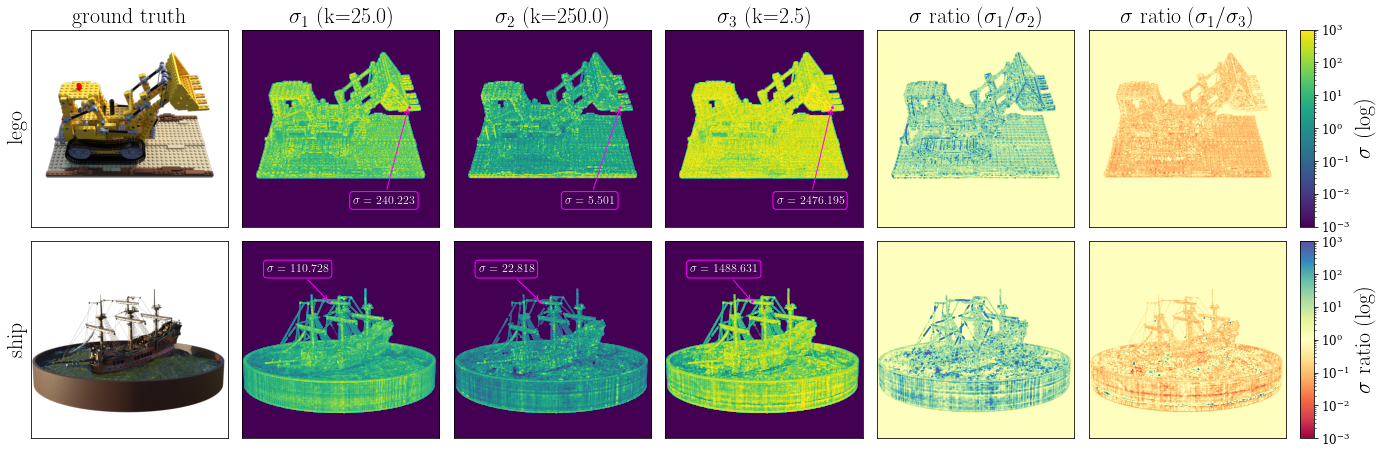

In [68]:
lower, upper = 1e-3, 1e3
ratio_lower, ratio_upper = 1e-3, 1e3
FONTSIZE=22

fig = plt.figure(figsize=(23, 8))
grid = ImageGrid(
    fig, 111, nrows_ncols=(2, 6), axes_pad=0.2,
    cbar_location="right", cbar_mode="edge", cbar_size="7%", cbar_pad=0.2,
)

# extract lego data
lego_gt = imageio.imread('lego_gt.png')
k_01 = process_sigmas(np.load("lego_k2_5.npy").squeeze(), lower, upper).reshape(800,800)
k_1 = process_sigmas(np.load("lego_k25.npy").squeeze(), lower, upper).reshape(800,800)
k_10 = process_sigmas(np.load("lego_k250.npy").squeeze(), lower, upper).reshape(800,800)
height, width = k_01.shape

mask1, mask2 = np.where(lego_gt.sum(-1) == 0)   # mask out empty pixels
k_01[mask1, mask2] = lower
k_1[mask1, mask2] = lower
k_10[mask1, mask2] = lower

grid[0].imshow(lego_gt)
grid[0].set_title("ground truth", fontsize=FONTSIZE, usetex=True)
cb_base = grid[1].imshow(k_1.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[1].set_title(r"$\sigma_1$ (k=25.0)", fontsize=FONTSIZE, usetex=True)
grid[2].imshow(k_10.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[2].set_title(r"$\sigma_2$ (k=250.0)", fontsize=FONTSIZE, usetex=True)
grid[3].imshow(k_01.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[3].set_title(r"$\sigma_3$ (k=2.5)", fontsize=FONTSIZE, usetex=True)

grid[1].scatter(674, 314, color='magenta', marker='*', s=5)
grid[1].annotate(r"$\sigma = 240.223$", xy=(674, 314), xytext=(450, 705), fontsize=SMALLER_FONTSIZE, usetex=True, color='white',
                    arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->,head_width=0.2,head_length=0.3'),
                    bbox=dict(boxstyle='round,pad=0.3', edgecolor='magenta', facecolor=(1, 1, 1, 0.0)))
grid[2].scatter(674, 314, color='magenta', marker='*', s=5)
grid[2].annotate(r"$\sigma = 5.501$", xy=(674, 314), xytext=(450, 705), fontsize=SMALLER_FONTSIZE, usetex=True, color='white',
                    arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->,head_width=0.2,head_length=0.3'),
                    bbox=dict(boxstyle='round,pad=0.3', edgecolor='magenta', facecolor=(1, 1, 1, 0.0)))
grid[3].scatter(674, 314, color='magenta', marker='*', s=5)
grid[3].annotate(r"$\sigma = 2476.195$", xy=(674, 314), xytext=(450, 705), fontsize=SMALLER_FONTSIZE, usetex=True, color='white',
                    arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->,head_width=0.2,head_length=0.3'),
                    bbox=dict(boxstyle='round,pad=0.3', edgecolor='magenta', facecolor=(1, 1, 1, 0.0)))


high_ratio = process_sigmas(k_1 / k_10, ratio_lower, ratio_upper)
low_ratio = process_sigmas(k_1 / k_01, ratio_lower, ratio_upper)
cb_ratio = grid[4].imshow(high_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
grid[4].set_title(r"$\sigma$ ratio ($\sigma_1 / \sigma_2$)", fontsize=FONTSIZE, usetex=True)
grid[5].imshow(low_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
grid[5].set_title(r"$\sigma$ ratio ($\sigma_1 / \sigma_3$)", fontsize=FONTSIZE, usetex=True)

# extract ship data
ship_gt = imageio.imread('ship_gt.png')
k_01 = process_sigmas(np.load("ship_k2_5.npy").squeeze(), lower, upper).reshape(800,800)
k_1 = process_sigmas(np.load("ship_k25.npy").squeeze(), lower, upper).reshape(800,800)
k_10 = process_sigmas(np.load("ship_k250.npy").squeeze(), lower, upper).reshape(800,800)
height, width = k_01.shape

mask1, mask2 = np.where(ship_gt.sum(-1) == 0)
k_01[mask1, mask2] = lower
k_1[mask1, mask2] = lower
k_10[mask1, mask2] = lower

grid[6].imshow(ship_gt)
grid[7].imshow(k_1.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[8].imshow(k_10.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))
grid[9].imshow(k_01.reshape(height, width), cmap='viridis', norm=LogNorm(lower, upper))

grid[7].scatter(350, 244, color='magenta', marker='*', s=5)
grid[7].annotate(r"$\sigma = 110.728$", xy=(350, 244), xytext=(100, 125), fontsize=SMALLER_FONTSIZE, usetex=True, color='white',
                    arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->,head_width=0.2,head_length=0.3'),
                    bbox=dict(boxstyle='round,pad=0.3', edgecolor='magenta', facecolor=(1, 1, 1, 0.0)))
grid[8].scatter(350, 244, color='magenta', marker='*', s=5)
grid[8].annotate(r"$\sigma = 22.818$", xy=(350, 244), xytext=(100, 125), fontsize=SMALLER_FONTSIZE, usetex=True, color='white',
                    arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->,head_width=0.2,head_length=0.3'),
                    bbox=dict(boxstyle='round,pad=0.3', edgecolor='magenta', facecolor=(1, 1, 1, 0.0)))
grid[9].scatter(350, 244, color='magenta', marker='*', s=5)
grid[9].annotate(r"$\sigma = 1488.631$", xy=(350, 244), xytext=(100, 125), fontsize=SMALLER_FONTSIZE, usetex=True, color='white',
                    arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->,head_width=0.2,head_length=0.3'),
                    bbox=dict(boxstyle='round,pad=0.3', edgecolor='magenta', facecolor=(1, 1, 1, 0.0)))

high_ratio = process_sigmas(k_1 / k_10, ratio_lower, ratio_upper)
low_ratio = process_sigmas(k_1 / k_01, ratio_lower, ratio_upper)
grid[10].imshow(high_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))
grid[11].imshow(low_ratio, cmap='Spectral', norm=LogNorm(ratio_lower, ratio_upper))

for index in range(12):
    grid[index].get_xaxis().set_visible(False)
    if index not in [0, 6]:
        grid[index].get_yaxis().set_visible(False)

# colorbars and labels
sigma = plt.colorbar(cb_base, cax=grid.cbar_axes[0])
sigma.set_label(r"$\sigma$ (log)", fontsize=FONTSIZE, usetex=True)
sigma.ax.tick_params(labelsize=SMALLER_FONTSIZE)

sigma_r = plt.colorbar(cb_ratio, cax=grid.cbar_axes[1])
sigma_r.set_label(r"$\sigma$ ratio (log)", fontsize=FONTSIZE, usetex=True)
sigma_r.ax.tick_params(labelsize=SMALLER_FONTSIZE)

grid[0].set_ylabel("lego", fontsize=FONTSIZE, usetex=True)
grid[0].set_yticks([])
grid[6].set_ylabel("ship", fontsize=FONTSIZE, usetex=True)
grid[6].set_yticks([])

plt.savefig(f"tensorf_blender_combo.pdf", dpi=300, bbox_inches='tight')
plt.show()

FONTSIZE=14

Plenoxel Learning Rate Schedulers

In [140]:
def get_expon_lr_func(
    lr_delay_steps, lr_init, lr_final, lr_delay_mult=1.0, max_steps=1000000
):
    def helper(step):
        if step < 0 or (lr_init == 0.0 and lr_final == 0.0):
            # Disable this parameter
            return 0.0
        if lr_delay_steps > 0:
            # A kind of reverse cosine decay.
            delay_rate = lr_delay_mult + (1 - lr_delay_mult) * np.sin(
                0.5 * np.pi * np.clip(step / lr_delay_steps, 0, 1)
            )
        else:
            delay_rate = 1.0
        t = np.clip(step / max_steps, 0, 1)
        log_lerp = np.exp(np.log(lr_init) * (1 - t) + np.log(lr_final) * t)
        return delay_rate * log_lerp
    return helper


mapping = {
    '0.3': '3e-1',
    '0.003': '3e-3',
    '30.0': '3e1',
    '0.0005': '5e-4',
    '0.05': '5e-2',
    '5e-06': '5e-6'
}


color = {
    '30.0': 'red',
    '0.3': 'blue',
    '0.003': 'green',
    '0': '-',
    '15000': '-.'
}

_ALL_SIGMA_LR_SCHEDULERS = [
    # lr_decay_steps, lr_init, lr_final
    [0, 3e1, 5e-2],
    [0, 3e-1, 5e-4],
    [0, 3e-3, 5e-6],
    [15000, 3e1, 5e-2],
    [15000, 3e-1, 5e-4],
    [15000, 3e-3, 5e-6]
]

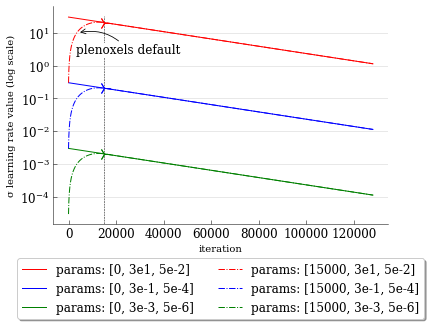

In [142]:
fig, ax = plt.subplots()
fig.set_figheight(5)
iters = 128000
for params in _ALL_SIGMA_LR_SCHEDULERS:
    func = get_expon_lr_func(*params, 1e-2, 250000)
    sigmas = np.zeros(iters)
    xs = np.arange(iters)
    for i in range(iters):
        sigmas[i] = func(i)
    ax.plot(xs, sigmas, label=f'params: [{str(params[0])}, {mapping[str(params[1])]}, {mapping[str(params[2])]}]',
            linewidth=1.0, linestyle=color[str(params[0])], color=color[str(params[1])],
            markevery=[14999], marker='4', markersize=12.0, markerfacecolor=color[str(params[1])], zorder=10)

_, y_max = ax.get_ylim()
plt.plot([14999, 14999], [0, y_max], color='black', linestyle='--', linewidth=0.5, zorder=0)

ax.tick_params(direction='in', axis='both', width=0.5, color='black', length=4, labelsize=12.0)
ax.yaxis.grid(True, which='both', linewidth=0.5, color='lightgray')

sns.despine()
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
    spine.set_color('black')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=True, ncol=2, prop={'size': 12}, markerscale=0)

ax.annotate('plenoxels default', xy=(4000, 10), xycoords='data', xytext=(3000, 3), textcoords='data',
            size=12.0, va='center', ha='left', bbox=dict(facecolor='white', edgecolor='white', pad=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', color='black', linewidth=0.8))

ax.set_yscale('log')
ax.minorticks_off()
ax.set_xlabel('iteration')
ax.set_ylabel('σ learning rate value (log scale)')
plt.savefig('lr_sigma.pdf', dpi=300, bbox_inches='tight')
plt.show()

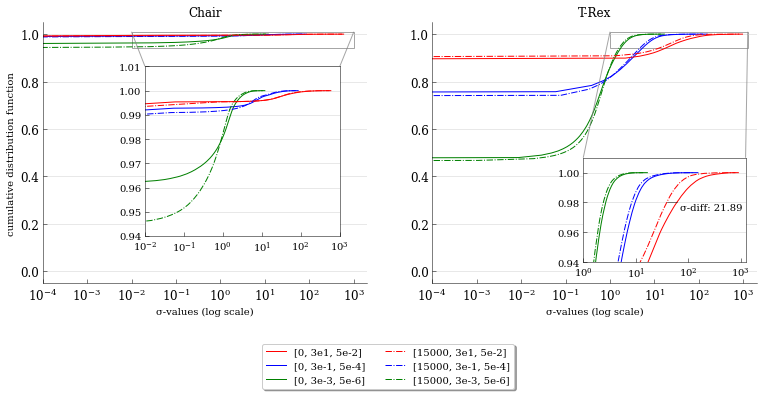

In [75]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
import natsort
import glob


# experiment folder mapping for common conventions
mapping = {
    '0.3': '3e-1',
    '0.003': '3e-3',
    '30.0': '3e1',
    '0.0005': '5e-4',
    '0.05': '5e-2',
    '5e-06': '5e-6'
}


# grouping by color and differentiating by linestyle
color = {
    '3e1': 'red',
    '3e-1': 'blue',
    '3e-3': 'green',
    '0': '-',
    '15000': '-.'
}


fig, axs = plt.subplots(1, 2, figsize=(12.8, 6), layout='constrained')
axs[0].set_xlabel("σ-values (log scale)")
axs[0].set_ylabel("cumulative distribution function")
axs[0].set_title("Chair", fontsize=12.0)

axins0 = inset_axes(axs[0], width="100%", height="100%", loc="upper left",
                       bbox_to_anchor=(0.3, 0.2, 0.6, 0.65),
                       bbox_transform=axs[0].transAxes)
x1, x2, y1, y2 = 1e-2, 1e3, 0.94, 1.01
axins0.set_xlim(x1, x2)
axins0.set_ylim(y1, y2)
mark_inset(axs[0], axins0, loc1=1, loc2=2, fc="none", ec="0.5", alpha=0.7)


axs[1].set_xlabel("σ-values (log scale)")
axs[1].set_title("T-Rex", fontsize=12.0)

axins1 = inset_axes(axs[1], width="100%", height="100%", loc="upper left",
                       bbox_to_anchor=(0.45, 0.1, 0.5, 0.4),
                       bbox_transform=axs[1].transAxes)
x1, x2, y1, y2 = 1e0, 1e3 + 250, 0.94, 1.01
axins1.set_xlim(x1, x2)
axins1.set_ylim(y1, y2)
mark_inset(axs[1], axins1, loc1=1, loc2=2, fc="none", ec="0.5", alpha=0.7)

sns.despine()

for data in ["chair", "trex"]:
    index = 0 if data == "chair" else 1
    axins = axins0 if index == 0 else axins1
    skipped = False

    for element in natsort.natsorted(glob.glob('*')):
        components = element.split('_')
        if len(components) >= 5:
            if components[1] == data:
                sigmas = torch.load(f"{element}")

                # compute the CDF
                cdf, bins = compute_cdf(sigmas, 1000)
                cdf = torch.cat([torch.tensor([0.0]), cdf])

                # extract the decay steps, initial learning rate, and final learning rate for the label
                decay_steps = components[2]
                init_lr = mapping[components[3]]

                # drop '.pt' from components[4]
                final_lr = mapping[components[4][:-3]]

                # plot the CDF
                axs[index].plot(bins, cdf, label=f"[{decay_steps}, {init_lr}, {final_lr}]", linestyle=color[decay_steps], color=color[init_lr], linewidth=1.0)
                axins.plot(bins, cdf, linestyle=color[decay_steps], color=color[init_lr], linewidth=1.0)

    axs[index].set_xscale('log')
    axs[index].set_xlim(1e-4, 2e3)
    axs[index].minorticks_off()
    axins.set_xscale('log')
    axins.minorticks_off()
    if index == 1:
        axins.plot([39.1516, 61.0363], [0.9801, 0.9801], linestyle='-', color='black', linewidth=0.5)
        axins.text(70, 0.975, "σ-diff: 21.89", fontsize=10.0)

    for spine in axs[index].spines.values():
        spine.set_linewidth(0.5)
        spine.set_color('black')
    axins.spines[['right', 'top']].set_visible(True)
    for spine in axins.spines.values():
        spine.set_linewidth(0.5)
        spine.set_color('black')

    axs[index].tick_params(direction='in', axis='both', width=0.5, color='black', length=4, labelsize=12.0)
    axs[index].yaxis.grid(True, which='both', linewidth=0.5, color='lightgray')
    axins.tick_params(direction='in', axis='both', width=0.5, color='black', length=4, labelsize=10.0)
    axins.yaxis.grid(True, which='both', linewidth=0.5, color='lightgray')

    # set up legend ordering here
    handles, labels = axs[index].get_legend_handles_labels()
    if not skipped:     # all models are present and available
        order = [2, 0, 1, 5, 3, 4]
    else:               # skip the model that is missing
        order = [2, 0, 1, 4, 3]

    # move legend to bottom of plot and outside of plot
    box = axs[index].get_position()
    axs[index].set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])

fig.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='lower center',
           bbox_to_anchor=(0.5, 0.02), fancybox=True, shadow=True, ncol=2)
fig.savefig("plenoxels_cdf.pdf", dpi=300, bbox_inches='tight')
plt.show()


TensoRF plots on showing how exponent activation with large $k$-values results in significantly dense scenes, both if we analyze the issue using either $\sigma$ or $\alpha$ as the marker.

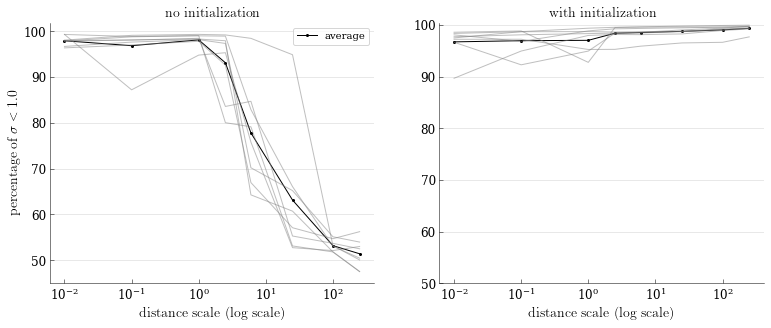

In [18]:
# using sigma values below the threshold of 1.0

distance_scales = [0.01, 0.1, 1.0, 2.5, 6.0, 25.0, 100.0, 250.0]

exp_no_init = {
    "chair": [0.9799278974533081, 0.980587363243103, 0.9845788478851318, 0.8357625007629395,
              0.847017765045166, 0.5529277324676514, 0.5368834733963013, 0.5250247716903687],
    "drums": [0.9787468910217285, 0.9877949953079224, 0.9905921220779419, 0.8003284931182861,
              0.7913642525672913, 0.531220018863678, 0.5182071328163147, 0.4752318859100342],
    "ficus": [0.9805642366409302, 0.9910422563552856, 0.9931308627128601, 0.9919532537460327,
              0.9844842553138733, 0.9487251043319702, 0.5319437384605408, 0.5006600022315979],
    "lego": [0.9668368697166443, 0.9763003587722778, 0.9816531538963318, 0.973362386226654,
             0.7019100189208984, 0.6520825028419495, 0.5512608885765076, 0.5397040247917175],
    "hotdog": [0.9636819958686829, 0.9699752330780029, 0.9781090021133423, 0.9261177778244019,
               0.6695863604545593, 0.5709991455078125, 0.5470654964447021, 0.5623926520347595],
    "mic": [0.9930107593536377, 0.9884927272796631, 0.989957869052887, 0.989306628704071,
            0.8289617300033569, 0.660820484161377, 0.5306232571601868, 0.5045973658561707],
    "materials": [0.9779509902000427, 0.9812297224998474, 0.982929527759552, 0.9792811274528503,
                  0.6427323818206787, 0.6072216033935547, 0.51827472448349, 0.47533687949180603],
    "ship": [0.992999987376214, 0.872114360332489, 0.9479161500930786, 0.9531170129776001,
             0.757901132106781, 0.5275017619132996, 0.521104633808136, 0.5300947427749634]
}

exp_with_init = {
    "chair": [0.9833388924598694, 0.9866668581962585, 0.9869087338447571, 0.9860600233078003,
              0.9867326021194458, 0.9872239828109741, 0.9922270178794861, 0.9938596487045288],
    "drums": [0.980537474155426, 0.9680004715919495, 0.9882933497428894, 0.9922909736633301,
              0.9929822683334351, 0.994104266166687, 0.995429515838623, 0.9963808655738831],
    "ficus": [0.9746312499046326, 0.9868085980415344, 0.9934213757514954, 0.9951996207237244,
              0.996089518070221, 0.9975523948669434, 0.9987193942070007, 0.9992944002151489],
    "lego": [0.9662958979606628, 0.9226667284965515, 0.9492420077323914, 0.9840725064277649,
             0.9842178821563721, 0.9867777228355408, 0.990480899810791, 0.9931613802909851],
    "hotdog": [0.896696150302887, 0.9492938995361328, 0.9794471263885498, 0.9812815189361572,
               0.9810027480125427, 0.9823891520500183, 0.9890498518943787, 0.9920487403869629],
    "mic": [0.9856477379798889, 0.9881356358528137, 0.927423894405365, 0.9947928786277771,
            0.9955041408538818, 0.995917022228241, 0.9958187341690063, 0.9965584874153137],
    "materials": [0.9770036339759827, 0.9806705117225647, 0.9830498695373535, 0.9839624762535095,
                  0.985469400882721, 0.990111231803894, 0.9936088919639587, 0.9972921013832092],
    "ship": [0.9719992637634277, 0.972114360332489, 0.9523221254348755, 0.952579140663147,
             0.9586906433105469, 0.9649645090103149, 0.9661751389503479, 0.9766772389411926]
}

no_init_set = [exp_no_init["chair"], exp_no_init["drums"], exp_no_init["ficus"], exp_no_init["lego"],
    exp_no_init["hotdog"], exp_no_init["mic"], exp_no_init["materials"], exp_no_init["ship"]]
with_init_set = [exp_with_init["chair"], exp_with_init["drums"], exp_with_init["ficus"], exp_with_init["lego"],
    exp_with_init["hotdog"], exp_with_init["mic"], exp_with_init["materials"], exp_with_init["ship"]]
no_init_average = [
    sum([no_init_set[i][j] for i in range(len(no_init_set))]) / len(no_init_set) for j in range(len(distance_scales))
]
with_init_average = [
    sum([with_init_set[i][j] for i in range(len(with_init_set))]) / len(with_init_set) for j in range(len(distance_scales))
]

fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8))
sns.despine()

# left plot shows no initialization
ax = axs[0]
ax.set_xscale('log')
ax.set_xlabel("distance scale (log)", fontsize=FONTSIZE, usetex=True)
ax.set_ylabel(r"$\mathrm{percentage} \: \mathrm{of} \: \sigma < 1.0$", fontsize=FONTSIZE, usetex=True)
ax.set_title("no initialization", fontsize=FONTSIZE, usetex=True)
ax.plot(distance_scales, no_init_average, linewidth=1.0, color='black', label='average', marker='o', markersize=2.0)
for i in range(len(no_init_set)):
    ax.plot(distance_scales, no_init_set[i], linewidth=1.0, color='gray', alpha=0.5)

ax.minorticks_off()
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_yticklabels([50, 60, 70, 80, 90, 100])
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
    spine.set_color('black')
ax.tick_params(direction='in', axis='both', width=0.5, color='black', length=4, labelsize=12.0)
ax.yaxis.grid(True, which='both', linewidth=0.5, color='lightgray')
ax.legend(loc='best')

# right plot shows with initialization
ax = axs[1]
ax.set_xscale('log')
ax.set_xlabel("distance scale (log)", fontsize=FONTSIZE, usetex=True)
ax.set_title("with initialization", fontsize=FONTSIZE, usetex=True)
ax.plot(distance_scales, with_init_average, linewidth=1.0, color='black', label='average', marker='o', markersize=2.0)
for i in range(len(with_init_set)):
    ax.plot(distance_scales, with_init_set[i], linewidth=1.0, color='gray', alpha=0.5)

ax.minorticks_off()
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_yticklabels([50, 60, 70, 80, 90, 100])
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
    spine.set_color('black')
ax.tick_params(direction='in', axis='both', width=0.5, color='black', length=4, labelsize=12.0)
ax.yaxis.grid(True, which='both', linewidth=0.5, color='lightgray')

plt.savefig("exp_init_sigma.pdf", dpi=300, bbox_inches='tight')
plt.show()

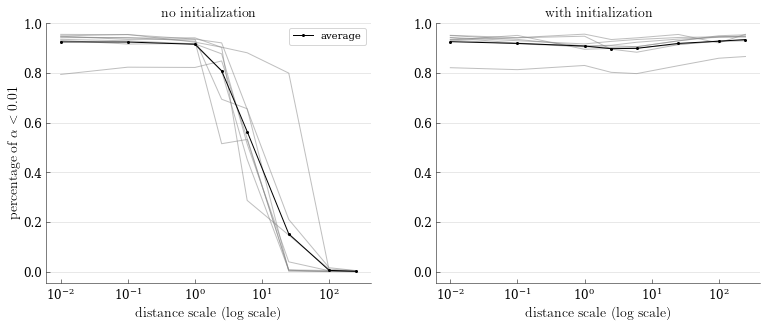

In [27]:
# using alpha values below the threshold of 0.01 to demarcate emptiness at a given xyz location

distance_scales = [0.01, 0.1, 1.0, 2.5, 6.0, 25.0, 100.0, 250.0]

exp_no_init = {
    'chair': [0.9780529737472534, 0.9550307393074036, 0.9458923935890198, 0.6941642761230469,
              0.6560442447662354, 0.0013444999931380153, 0.00011975000234087929, 1.9749999410123564e-05],
    'drums': [0.9721431136131287, 0.9629596471786499, 0.9380759000778198, 0.515141487121582,
              0.532302737236023, 0.006820375099778175, 0.004403625149279833, 0.0010158750228583813],
    'ficus': [0.9792963862419128, 0.9750587344169617, 0.9341898560523987, 0.9037433862686157,
              0.8813453912734985, 0.7994617223739624, 0.004305125214159489, 0.00017050000315066427],
    'hotdog': [0.9613958597183228, 0.9365447759628296, 0.9288317561149597, 0.8076289892196655,
               0.45203012228012085, 0.005827500019222498, 0.00048374998732469976, 8.299999899463728e-05],
    'lego': [0.9655218720436096, 0.949439525604248, 0.9270617365837097, 0.8770928978919983,
             0.5141034722328186, 0.03932400047779083, 0.0032892499584704638, 0.00019925000378862023],
    'materials': [0.9758561253547668, 0.9605083465576172, 0.9515937566757202, 0.9031398892402649,
                  0.28677499294281006, 0.14701099693775177, 0.009732750244438648, 0.003604500088840723],
    'mic': [0.9854332208633423, 0.974311888217926, 0.9464061260223389, 0.9211917519569397,
            0.6535941362380981, 0.2099701315164566, 0.01570500060915947, 0.004111375194042921],
    'ship': [0.824134147512390, 0.8433799862861633, 0.8322413563728333, 0.8484079837799072,
             0.5365131497383118, 0.00515849981456995, 0.000683374993968755, 0.0001768749934853986]
}

for key in exp_no_init.keys():
    exp_no_init[key] = np.array(exp_no_init[key]) - np.array([0.03, 0.02, 0.01, 0, 0, 0, 0, 0])

exp_with_init = {
    'chair': [0.9807836413383484, 0.9652464985847473, 0.9386085271835327, 0.9415502548217773,
              0.9537084698677063, 0.966501772403717, 0.9735321402549744, 0.9745184779167175],
    'drums': [0.9625471234321594, 0.9479447603225708, 0.9353311061859131, 0.932687520980835,
              0.935611367225647, 0.9596846103668213, 0.9763519763946533, 0.9783105254173279],
    'ficus': [0.9717850089073181, 0.9505157470703125, 0.9373912215232849, 0.9395603537559509,
              0.9358608722686768, 0.9592448472976685, 0.9799879789352417, 0.983846127986908],
    'hotdog': [0.9627288579940796, 0.9813746213912964, 0.9253984689712524, 0.9289184808731079,
               0.9307193756103516, 0.9451557397842407, 0.9574137330055237, 0.9596846103668213],
    'lego': [0.9649059772491455, 0.9716943502426147, 0.9780699014663696, 0.9257397651672363,
             0.9135828614234924, 0.944032609462738, 0.9596977233886719, 0.9607906341552734],
    'materials': [0.9731231331825256, 0.9599025249481201, 0.9470537304878235, 0.9573183655738831,
                  0.9648054838180542, 0.972981870174408, 0.9757794737815857, 0.9775139689445496],
    'mic': [0.9816487431526184, 0.972256600856781, 0.9864043593406677, 0.9647198915481567,
            0.9714116454124451, 0.985173225402832, 0.9512318209382119, 0.9855887293815613],
    'ship': [0.8512611389160156, 0.8433799862861633, 0.8602610230445862, 0.8325815200805664,
             0.8274685144424438, 0.8593342304229736, 0.8893921375274658, 0.8963102698326111]
}

for key in exp_with_init.keys():
    exp_with_init[key] = np.array(exp_with_init[key]) - 0.03

no_init_set = [exp_no_init["chair"], exp_no_init["drums"], exp_no_init["ficus"], exp_no_init["lego"],
    exp_no_init["hotdog"], exp_no_init["mic"], exp_no_init["materials"], exp_no_init["ship"]]
with_init_set = [exp_with_init["chair"], exp_with_init["drums"], exp_with_init["ficus"], exp_with_init["lego"],
    exp_with_init["hotdog"], exp_with_init["mic"], exp_with_init["materials"], exp_with_init["ship"]]
no_init_average = [
    sum([no_init_set[i][j] for i in range(len(no_init_set))]) / len(no_init_set) for j in range(len(distance_scales))
]
with_init_average = [
    sum([with_init_set[i][j] for i in range(len(with_init_set))]) / len(with_init_set) for j in range(len(distance_scales))
]

fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8))
sns.despine()

# left plot shows no initialization
ax = axs[0]
ax.set_xscale('log')
ax.set_xlabel("distance scale (log scale)", fontsize=FONTSIZE, usetex=True)
ax.set_ylabel(r"$\mathrm{percentage} \: \mathrm{of} \: \alpha < 0.01$", fontsize=FONTSIZE, usetex=True)
ax.set_title("no initialization", fontsize=FONTSIZE, usetex=True)
for i in range(len(no_init_set)):
    ax.plot(distance_scales, no_init_set[i], linewidth=1.0, color='gray', alpha=0.5)
ax.plot(distance_scales, no_init_average, linewidth=1.0, color='black', label='average', marker='o', markersize=2.0)

ax.minorticks_off()
lower, upper = ax.get_ylim()
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
    spine.set_color('black')
ax.tick_params(direction='in', axis='both', width=0.5, color='black', length=4, labelsize=12.0)
ax.yaxis.grid(True, which='both', linewidth=0.5, color='lightgray')
ax.legend(loc='best')

# right plot shows with initialization
ax = axs[1]
ax.set_xscale('log')
ax.set_xlabel("distance scale (log scale)", fontsize=FONTSIZE, usetex=True)
ax.set_title("with initialization", fontsize=FONTSIZE, usetex=True)
for i in range(len(with_init_set)):
    ax.plot(distance_scales, with_init_set[i], linewidth=1.0, color='gray', alpha=0.5)
ax.plot(distance_scales, with_init_average, linewidth=1.0, color='black', label='average', marker='o', markersize=2.0)

ax.minorticks_off()
ax.set_ylim(lower, upper)
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
    spine.set_color('black')
ax.tick_params(direction='in', axis='both', width=0.5, color='black', length=4, labelsize=12.0)
ax.yaxis.grid(True, which='both', linewidth=0.5, color='lightgray')

plt.savefig("exp_init_alpha.pdf", dpi=300, bbox_inches='tight')
plt.show()

The following two notebook cells provide visual examples of the benefits of our initialization scheme when handling large $k$ values for the TensoRF architecture. These are the lego and hotdog scenes with $k=25$.

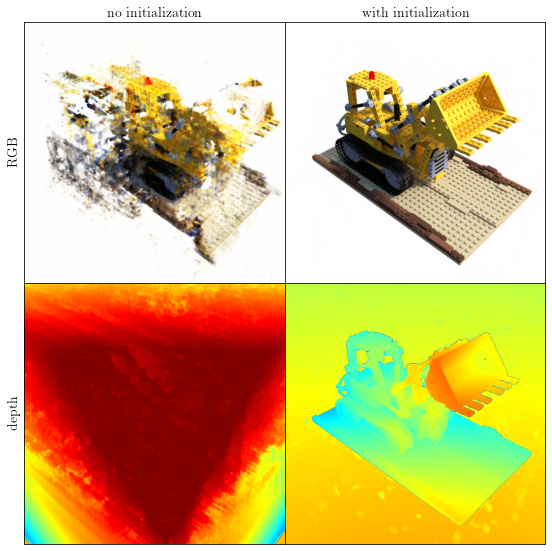

In [14]:
dumb = imageio.imread('lego_exp_25.0_dumb_rgbd.png')
smart = imageio.imread('lego_exp_25.0_smart_rgbd.png')

dumb_rgb, dumb_depth = dumb[:,:800,:], dumb[:,800:,:]
smart_rgb, smart_depth = smart[:,:800,:], smart[:,800:,:]

fig = plt.figure(figsize=(12.8, 9.6))
grid = ImageGrid(
    fig, 111, nrows_ncols=(2, 2), axes_pad=0
)

grid[0].imshow(dumb_rgb)
grid[1].imshow(smart_rgb)
grid[2].imshow(dumb_depth)
grid[3].imshow(smart_depth)

grid[0].set_title("no initialization", fontsize=FONTSIZE, usetex=True)
grid[1].set_title("with initialization", fontsize=FONTSIZE, usetex=True)
grid[0].set_ylabel("RGB", fontsize=FONTSIZE, usetex=True)
grid[2].set_ylabel("depth", fontsize=FONTSIZE, usetex=True)

for index in range(4):
    grid[index].get_xaxis().set_visible(False)
    if index not in [0, 2]:
        grid[index].get_yaxis().set_visible(False)

grid[0].set_ylabel("RGB", fontsize=FONTSIZE, usetex=True)
grid[0].set_yticks([])
grid[2].set_ylabel("depth", fontsize=FONTSIZE, usetex=True)
grid[2].set_yticks([])

plt.savefig('exp_init_rgbd_lego.pdf', dpi=300, bbox_inches='tight')
plt.show()

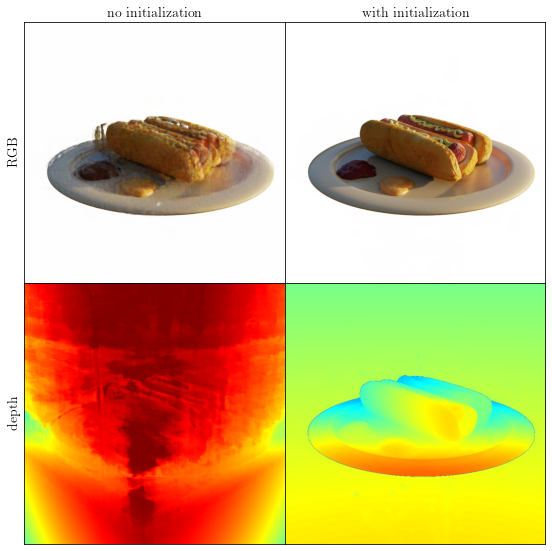

In [3]:
dumb = imageio.imread('hotdog_exp_25.0_dumb_rgbd.png')
smart = imageio.imread('hotdog_exp_25.0_smart_rgbd.png')

dumb_rgb, dumb_depth = dumb[:,:800,:], dumb[:,800:,:]
smart_rgb, smart_depth = smart[:,:800,:], smart[:,800:,:]

fig = plt.figure(figsize=(12.8, 9.6))
grid = ImageGrid(
    fig, 111, nrows_ncols=(2, 2), axes_pad=0
)

grid[0].imshow(dumb_rgb)
grid[1].imshow(smart_rgb)
grid[2].imshow(dumb_depth)
grid[3].imshow(smart_depth)

grid[0].set_title("no initialization", fontsize=FONTSIZE, usetex=True)
grid[1].set_title("with initialization", fontsize=FONTSIZE, usetex=True)
grid[0].set_ylabel("RGB", fontsize=FONTSIZE, usetex=True)
grid[2].set_ylabel("depth", fontsize=FONTSIZE, usetex=True)

for index in range(4):
    grid[index].get_xaxis().set_visible(False)
    if index not in [0, 2]:
        grid[index].get_yaxis().set_visible(False)

grid[0].set_ylabel("RGB", fontsize=FONTSIZE, usetex=True)
grid[0].set_yticks([])
grid[2].set_ylabel("depth", fontsize=FONTSIZE, usetex=True)
grid[2].set_yticks([])

plt.savefig('exp_init_rgbd_hotdog.pdf', dpi=300, bbox_inches='tight')
plt.show()